In [1]:
!pip install -q featuretools

# Day 1 PM / Advanced Feature Engineering

Feature engineering consists of the creation of features whereas preprocessing involves cleaning the data.

## Resampling Imbalanced Data

> Always split into test and train sets BEFORE trying sampling techniques!

In practice, you will encounter imbalanced data more often than not. This does not necessarily have to be a problem if your target only has a slight imbalance. You could then resolve it by using proper validation measures for the data such as Balanced Accuracy, Precision-Recall Curves or F1-score.
Unfortunately, this is not always the case and your target variable might be highly imbalanced (e.g., 10:1). Instead, you can oversample the minority target in order to introduce balance using a technique called SMOTE.

**SMOTE**

SMOTE stands for Synthetic Minority Oversampling Technique and is an oversampling technique used to increase the samples in a minority class.
It generates new samples by looking at the feature space of the target and detecting nearest neighbors. Then, it simply selects similar samples and changes a column at a time randomly within the feature space of the neighboring samples.

The module to implement SMOTE can be found within the imbalanced-learn package. You can simply import the package and apply a fit_transform:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import data and create X, y
df = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/PFDS_sources/master/creditcard_small.csv')
X = df.iloc[:,:-1]
y = df.iloc[:,-1].map({1:'Fraud', 0:'No Fraud'})

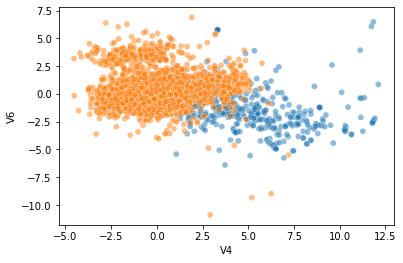

In [4]:
sns.scatterplot(x=X.V4, y=X.V6, hue=y, alpha=.5, legend=False)

In [5]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy='minority').fit_resample(X, y)
X_resampled, y_resampled = SMOTE(sampling_strategy={"Fraud":1000}).fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

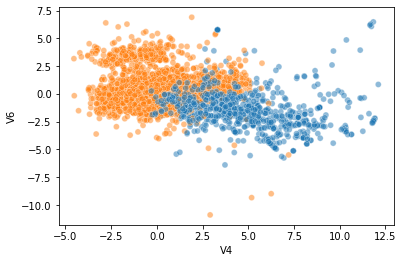

In [6]:
sns.scatterplot(x=X_resampled.V4, y=X_resampled.V6, hue=y_resampled, alpha=.5, legend=False)

As you can see the model successfully oversampled the target variable. There are several strategies that you can take when oversampling using SMOTE:

- 'minority': resample only the minority class;
- 'not minority': resample all classes but the minority class;
- 'not majority': resample all classes but the majority class;
- 'all': resample all classes;
- When dict, the keys correspond to the targeted classes. The values correspond to the desired number of samples for each targeted class.

We chose to use a dictionary to specify the extent to which we wanted to oversample our data.

Additional tip 1: If you have categorical variables in your dataset SMOTE is likely to create values for those variables that cannot happen. For example, if you have a variable called isMale, which could only take 0 or 1, then SMOTE might create 0.365 as a value.

Instead, you can use SMOTENC which takes into account the nature of categorical variables. This version is also available in the imbalanced-learn package.

Additional tip 2: Make sure to oversample after creating the train/test split so that you only oversample the train data. You typically do not want to test your model on synthetic data.

**Edited Nearest Neighbors**

The opposite of oversampling the class with fewer examples is undersampling the class with more. Using the approach of Edited Nearest Neighbors we can strategically undersample data points.

In [7]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
x_train_enn, y_train_enn = enn.fit_resample(X, y)
X_resampled = pd.DataFrame(x_train_enn, columns=X.columns)

**Undersampling + Oversampling**

Another popular method is combining the two approaches. We can oversample using SMOTE and then clean the data points using ENN. This is referred to as SMOTEENN in imblearn.

In [8]:
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=42)
x_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X, y)
X_resampled = pd.DataFrame(x_train_smoteenn, columns=X.columns)

## Creating New Features

To improve the quality and predictive power of our models, new features from existing variables are often created. We can create some interaction (e.g., multiply or divide) between each pair of variables hoping to find an interesting new feature. This, however, is a lengthy process and requires a significant amount of coding. Fortunately, this can be automated using Deep Feature Synthesis.

**Deep Feature Synthesis**

Deep feature synthesis (DFS) is an algorithm which enables you to quickly create new variables with varying depth. For example, you can multiply pairs of columns but you can also choose to first multiply Column A with Column B and then add Column C.

First, let me introduce the data We will be using for the example. We have chosen to use HR analytics data since the features are easily interpretable:

In [9]:
turnover_df = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/PFDS_sources/master/turnover.csv')
turnover_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


What is Featuretools?\
Featuretools is a framework to perform automated feature engineering. It excels at transforming temporal and relational datasets into feature matrices for machine learning.

what is Entity?\
An entity is simply a table or in pandas, a data frame. An entity in featuretools must have a unique index where none of the elements are duplicated.

what is Entity Set?\
An entity set is a collection of tables and relationships between them.This can be thought as a data structure with own methods and attributes. For each relationship we need to specify the parent variable and the child variable.

what are the primitives?\
A feature primitive is an operation applied to a table or a set of tables to create a feature.
Feature primitives are of two types: Aggregation , Transformation

**Feature Engineering using Featuretools**

Now we can start using Featuretools to perform automated feature engineering! It is necessary to have a unique identifier feature in the data set (loan_id). we have an id but if you don’t have unique id then it will be created. Suppose you have two different ids for two different data sets and you want a unique id then simply concentrating both will solve your problem.
Now it’s time to create our entity set step by step.

step1:
- create and entity set is es
- adding a dataframe

In [10]:
import featuretools as ft

# Create Entity
es = ft.EntitySet(id = 'Turnover')
es.add_dataframe(dataframe_name = 'hr', dataframe = turnover_df, index = 'index')

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entityset.py:1568: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: Turnover
  DataFrames:
    hr [Rows: 14999, Columns: 11]
  Relationships:
    No relationships

step 2:
let’s check summary of our entity set.

In [11]:
es

Entityset: Turnover
  DataFrames:
    hr [Rows: 14999, Columns: 11]
  Relationships:
    No relationships

step 3:
Now we will use Deep Feature Synthesis to create new features automatically. Recall that DFS uses Feature Primitives to create features using multiple tables present in the EntitySet.

In [12]:
default_agg_primitives =  ['add_numeric', 'multiply_numeric']


# DFS with specified primitive
feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'hr',
                       trans_primitives=default_agg_primitives)

print('%d Total Features' % len(feature_defs))

/usr/local/lib/python3.7/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:156: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one dataframe in entityset, changing max_depth to "


66 Total Features


The first step is to create an entity from which relationships can be created with other tables if necessary. Next, we can simply run ft.dfs in order to create new variables. We specify how variables are created with the parameter trans_primitives. We chose to either add numeric variables together or multiply.

In [13]:
feature_matrix.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,average_montly_hours + Work_accident,average_montly_hours + last_evaluation,average_montly_hours + left,average_montly_hours + number_project,average_montly_hours + promotion_last_5years,average_montly_hours + satisfaction_level,average_montly_hours + time_spend_company,last_evaluation + Work_accident,last_evaluation + left,last_evaluation + number_project,last_evaluation + promotion_last_5years,last_evaluation + satisfaction_level,last_evaluation + time_spend_company,left + Work_accident,left + number_project,left + promotion_last_5years,left + satisfaction_level,left + time_spend_company,number_project + Work_accident,number_project + promotion_last_5years,number_project + satisfaction_level,number_project + time_spend_company,promotion_last_5years + Work_accident,promotion_last_5years + satisfaction_level,promotion_last_5years + time_spend_company,satisfaction_level + Work_accident,satisfaction_level + time_spend_company,time_spend_company + Work_accident,average_montly_hours * Work_accident,average_montly_hours * last_evaluation,average_montly_hours * left,average_montly_hours * number_project,average_montly_hours * promotion_last_5years,average_montly_hours * satisfaction_level,average_montly_hours * time_spend_company,last_evaluation * Work_accident,last_evaluation * left,last_evaluation * number_project,last_evaluation * promotion_last_5years,last_evaluation * satisfaction_level,last_evaluation * time_spend_company,left * Work_accident,left * number_project,left * promotion_last_5years,left * satisfaction_level,left * time_spend_company,number_project * Work_accident,number_project * promotion_last_5years,number_project * satisfaction_level,number_project * time_spend_company,promotion_last_5years * Work_accident,promotion_last_5years * satisfaction_level,promotion_last_5years * time_spend_company,satisfaction_level * Work_accident,satisfaction_level * time_spend_company,time_spend_company * Work_accident
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low,157.0,157.53,158.0,159.0,157.0,157.38,160.0,0.53,1.53,2.53,0.53,0.91,3.53,1.0,3.0,1.0,1.38,4.0,2.0,2.0,2.38,5.0,0.0,0.38,3.0,0.38,3.38,3.0,0.0,83.21,157.0,314.0,0.0,59.66,471.0,0.0,0.53,1.06,0.0,0.2014,1.59,0.0,2.0,0.0,0.38,3.0,0.0,0.0,0.76,6.0,0.0,0.0,0.0,0.0,1.14,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,262.0,262.86,263.0,267.0,262.0,262.80,268.0,0.86,1.86,5.86,0.86,1.66,6.86,1.0,6.0,1.0,1.80,7.0,5.0,5.0,5.80,11.0,0.0,0.80,6.0,0.80,6.80,6.0,0.0,225.32,262.0,1310.0,0.0,209.60,1572.0,0.0,0.86,4.30,0.0,0.6880,5.16,0.0,5.0,0.0,0.80,6.0,0.0,0.0,4.00,30.0,0.0,0.0,0.0,0.0,4.80,0.0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,272.0,272.88,273.0,279.0,272.0,272.11,276.0,0.88,1.88,7.88,0.88,0.99,4.88,1.0,8.0,1.0,1.11,5.0,7.0,7.0,7.11,11.0,0.0,0.11,4.0,0.11,4.11,4.0,0.0,239.36,272.0,1904.0,0.0,29.92,1088.0,0.0,0.88,6.16,0.0,0.0968,3.52,0.0,7.0,0.0,0.11,4.0,0.0,0.0,0.77,28.0,0.0,0.0,0.0,0.0,0.44,0.0
3,0.72,0.87,5,223,5,0,1,0,sales,low,223.0,223.87,224.0,228.0,223.0,223.72,228.0,0.87,1.87,5.87,0.87,1.59,5.87,1.0,6.0,1.0,1.72,6.0,5.0,5.0,5.72,10.0,0.0,0.72,5.0,0.72,5.72,5.0,0.0,194.01,223.0,1115.0,0.0,160.56,1115.0,0.0,0.87,4.35,0.0,0.6264,4.35,0.0,5.0,0.0,0.72,5.0,0.0,0.0,3.60,25.0,0.0,0.0,0.0,0.0,3.60,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,low,159.0,159.52,160.0,161.0,159.0,159.37,162.0,0.52,1.52,2.52,0.52,0.89,3.52,1.0,3.0,1.0,1.37,4.0,2.0,2.0,2.37,5.0,0.0,0.37,3.0,0.37,3.37,3.0,0.0,82.68,159.0,318.0,0.0,58.83,477.0,0.0,0.52,1.04,0.0,0.1924,1.56,0.0,2.0,0.0,0.37,3.0,0.0,0.0,0.74,6.0,0.0,0.0,0.0,0.0,1.11,0.0


In [14]:
feature_matrix[feature_matrix.columns[10:20]].head()

,average_montly_hours + Work_accident,average_montly_hours + last_evaluation,average_montly_hours + left,average_montly_hours + number_project,average_montly_hours + promotion_last_5years,average_montly_hours + satisfaction_level,average_montly_hours + time_spend_company,last_evaluation + Work_accident,last_evaluation + left,last_evaluation + number_project
index,,,,,,,,,,
0,157.0,157.53,158.0,159.0,157.0,157.38,160.0,0.53,1.53,2.53
1,262.0,262.86,263.0,267.0,262.0,262.80,268.0,0.86,1.86,5.86
2,272.0,272.88,273.0,279.0,272.0,272.11,276.0,0.88,1.88,7.88
3,223.0,223.87,224.0,228.0,223.0,223.72,228.0,0.87,1.87,5.87
4,159.0,159.52,160.0,161.0,159.0,159.37,162.0,0.52,1.52,2.52


In [15]:
corel = feature_matrix.corr().abs()

In [16]:
import numpy as np

upper=corel.where(np.triu(np.ones(corel.shape),k=1).astype(np.bool))
threshold=0.7
collinear_features=[column for column in upper.columns if any(upper[column]>threshold)]

As you can see in the image above we have created an additional 66 features using only a few lines of code. A few examples of the features that were created:

- last_evaluation multiplied with satisfaction_level
- left multiplied with promotion_last_5years
- average_monthly_hours multiplied with satisfaction_level plus time_spend_company

Additional tip 1: Note that the implementation here is relatively basic. The great thing about DFS is that it can create new variables from aggregations between tables (e.g., facts and dimensions). See this [link](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html#Creating-an-EntitySet) for an example.

Additional tip 2: Run ft.list_primitives()in order to see the full list of aggregation that you can do. It even handles timestamps, null values, and long/lat information.

## Handling Missing Values

As always, there is no one best way of dealing with missing values. Depending on your data it might be sufficient to simply fill them with the mean or mode of certain groups. However, there are advanced techniques that use known parts of the data to impute the missing values.

One such method is called IterativeImputer a new package in Scikit-Learn which is based on the popular R algorithm for imputing missing variables, MICE.

**Iterative Imputer**

Iterative imputation can model complex relationships between known values and predict missing features. This method is a multi-step process that creates a series of models to predict missing features based on the known values of other features.

Iterative imputation is a complicated algorithm, but the overall approach is relatively straightforward.

- Impute missing values with simple imputation. This step allows the models to fit and predict correctly.
- Determine an order of imputation. The implementation has several options. This parameter can affect the final predictions as previous predictions are used for future predictions.
- Impute one feature by training a model on all other features. The target variable is the feature being imputed that contains some known values.
- Repeat this process for each feature.
- Repeat the process across all features several times or until the changes between complete iterations are below a threshold tolerance.

Iterative imputation uses Bayesian Ridge regression as the default estimator; however, you can modify this to an estimator of your choice.

In [17]:
# explicitly require this experimental feature
# now you can import normally from sklearn.impute
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Load data
titanic = pd.read_csv("https://raw.githubusercontent.com/ardhiraka/PFDS_sources/master/titanic.csv")
titanic = titanic.loc[:, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Age     714 non-null    float64
 2   SibSp   891 non-null    int64  
 3   Parch   891 non-null    int64  
 4   Fare    891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB


In [18]:
# Run imputer with a Random Forest estimator

titanic_mice = titanic.copy()
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)
titanic_mice = pd.DataFrame(imp.fit_transform(titanic_mice), columns=titanic_mice.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [19]:
titanic_mice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    float64
 1   Age     891 non-null    float64
 2   SibSp   891 non-null    float64
 3   Parch   891 non-null    float64
 4   Fare    891 non-null    float64
dtypes: float64(5)
memory usage: 34.9 KB


The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.

Additional tip 1: If you have sufficient data, then it might be an attractive option to simply delete samples with missing data. However, keep in mind that it could create bias in your data. Perhaps the missing data follows a pattern that you miss out on.

Additional tip 2: The Iterative Imputer allows for different estimators to be used. After some testing, I found out that you can even use Catboost as an estimator! Unfortunately, LightGBM and XGBoost do not work since their random state names differ.

**KNN Imputation**

KNN Imputation provides a more detailed approach than simple imputation. Using the K-most similar records to the instance with the missing value, some dependencies between missing and non-missing values can be modeled.
Thus, this method is more flexible and can somewhat handle data that is missing at random.
KNN Imputation is more computationally expensive than simple imputation. Still, if your dataset is not in the range of 10s of millions of records, this method works fine.

In [20]:
from sklearn.impute import KNNImputer

titanic_knn = titanic.copy()

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
titanic_knn['Age'] = knn_imputer.fit_transform(titanic_knn[['Age']])
titanic_knn['Age'].isnull().sum()

0


There is no single method to handle missing values. Before applying any methods, it is necessary to understand the type of missing values, then check the datatype and skewness of the missing column, and then decide which method is best for a particular problem.

## Outlier Detection

At times this is not possible since a perfect understanding of the data is difficult to achieve. Instead, you can make use of Outlier Detection algorithms such as the popular Isolation Forest.

**Isolation Forest**

In the Isolation Forest Algorithm, the keyword is Isolation. In essence, the algorithm checks how easily a sample can be isolated. This results in an isolation number which is calculated by the number of splits, in a Random Decision Tree, needed to isolate a sample. This isolation number is then averaged over all trees.

In [21]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import seaborn as sns

credit_card = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/PFDS_sources/master/creditcard_small.csv')
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [22]:
X = credit_card.drop('Class', axis=1)
y = credit_card['Class']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


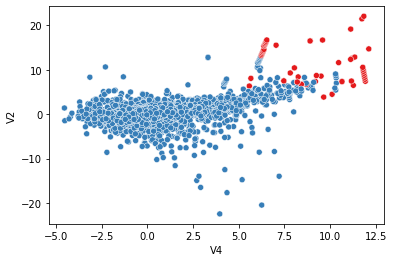

In [23]:
clf = IsolationForest(contamination=0.01)
outliers = clf.fit_predict(X)
sns.scatterplot(credit_card.V4, credit_card.V2, outliers, palette='Set1', legend=False)